In [15]:
# coding=utf-8
from __future__ import absolute_import, print_function
import argparse
import ast
import torch
import pandas as pd
from torchsummary import summary
from torch.backends import cudnn

import models
import DataSet
import json
from evaluations import Recall_at_ks, pairwise_similarity, extract_features, Compute_top_k
from utils.serialization import load_checkpoint, load_latest
from utils import display
cudnn.benchmark = True

def Model2Feature(data, net, checkpoint, dim=512, width=224, root=None, nThreads=16, batch_size=100, pool_feature=False, **kargs):
    dataset_name = data
    model = models.create(net, dim=dim, pretrained=False)
    model.load_state_dict(checkpoint['state_dict'], strict=True)
    try:
        model.load_state_dict(checkpoint['state_dict'], strict=True)
    except:
        print(
            'load checkpoint failed, the state in the '
            'checkpoint is not matched with the model, '
            'try to reload checkpoint with unstrict mode')
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.eval()
    #summary(model, input_size=(1, 256, 256))
    model = torch.nn.DataParallel(model).cuda()
    data = DataSet.create(data, width=width, root=root, mode='test')

    train_loader = torch.utils.data.DataLoader(
        data.train, batch_size=batch_size,
        shuffle=False, drop_last=False, pin_memory=True,
        num_workers=nThreads)
    test_loader = torch.utils.data.DataLoader(
        data.gallery, batch_size=batch_size,
        shuffle=False, drop_last=False, pin_memory=True,
        num_workers=nThreads)

    train_feature, train_labels \
        = extract_features(model, train_loader, print_freq=1e4,
                           metric=None, pool_feature=pool_feature)
    test_feature, test_labels \
        = extract_features(model, test_loader, print_freq=1e4,
                           metric=None, pool_feature=pool_feature)

    return train_feature, train_labels, test_feature, test_labels

parser = argparse.ArgumentParser(description='PyTorch Testing')

parser.add_argument('--data', type=str, default='cub')
parser.add_argument('--data_root', type=str, default=None)
parser.add_argument('--gallery_eq_query', '-g_eq_q', type=ast.literal_eval, default=False,
                    help='Is gallery identical with query')
parser.add_argument('--net', type=str, default='resnet18')
parser.add_argument('--resume', '-r', type=str, default='model.pkl', metavar='PATH')

parser.add_argument('--dim', '-d', type=int, default=512,
                    help='Dimension of Embedding Feather')
parser.add_argument('--width', type=int, default=224,
                    help='width of input image')

parser.add_argument('--batch_size', type=int, default=10)
parser.add_argument('--nThreads', '-j', default=2, type=int, metavar='N',
                    help='number of data loading threads (default: 2)')
parser.add_argument('--pool_feature', type=ast.literal_eval, default=False, required=False,
                    help='if True extract feature from the last pool layer')
parser.add_argument('--reload', type=str, default=None)
parser.add_argument('--save_dir', default=None, help='where the trained models saved')

args = parser.parse_args('--reload test'.split())
if args.reload != None:
    config_path = 'logs/experiments/{}/config.json'.format(args.reload)
    with open(config_path) as f:
        config = json.load(f)['args']
        display(argparse.Namespace(**config))
        args.width    = config['width']
        args.dim      = config['dim']
        args.net      = config['net']
        args.resume   = config['save_dir']
        args.data     = config['data']
        args.data_root= config['data_root']

Data Set 	whale
Network 	resnet18
Loss Function 	batchall
Embedded Dim 	256
Image size 	256
Learn Rate  	1.0e-05
Epochs  	00600
Batch Size  	100
Num-Instance  	10
Log Path 	logs/checkpoints/net_resnet18_256_loss_batchall_30_0.1_0.5_data_256_100_10
########################################


In [16]:
checkpoint = load_latest(args.resume)
if checkpoint == None:
    print('{} is not avaible! Exit!'.format(args.resume))

epoch = checkpoint['epoch']
train_feature, train_labels, test_feature, test_labels = \
    Model2Feature(data=args.data, root=args.data_root, width=args.width, net=args.net, checkpoint=checkpoint,
                   dim=args.dim, batch_size=args.batch_size, nThreads=args.nThreads, pool_feature=args.pool_feature)

=> Loaded checkpoint 'logs/checkpoints/net_resnet18_256_loss_batchall_30_0.1_0.5_data_256_100_10/ckp_ep260.pth.tar'


KeyError: 'unexpected key "_classifier.bn.weight" in state_dict'

In [12]:
# train-train pairwise similarity
sim_mat = pairwise_similarity(train_feature, train_feature)
sim_mat = sim_mat - torch.eye(sim_mat.size(0))
recall_ks, ks = Recall_at_ks(sim_mat, query_ids=train_labels, gallery_ids=train_labels, data=args.data)
result = '  '.join(['top@%d:%.4f' % (k, rc) for k, rc in zip(ks, recall_ks)])
print('Epoch-%d' % epoch, result)

Epoch-260 top@1:0.2843  top@5:0.4173  top@10:0.4782  top@20:0.5349


In [4]:
# test-train pairwise similarity
sim_mat = pairwise_similarity(test_feature, train_feature)
data = DataSet.create(args.data, width=args.width, mode='test')
submission_df = pd.read_csv('input/sample_submission.csv')

test


In [5]:
import numpy as np

def to_numpy(tensor):
    if torch.is_tensor(tensor):
        return tensor.cpu().numpy()
    elif type(tensor).__module__ != 'numpy':
        raise ValueError("Cannot convert {} to numpy array"
                         .format(type(tensor)))
    return tensor
k=5
print_freq=100

# start_time = time.time()
# print(start_time)
"""
:param sim_mat:

Compute
top-k in gallery for each query
"""

sim_mat = to_numpy(sim_mat)
labels = data.train.labels
m, n = sim_mat.shape
print('query number is %d' % m)
print('gallery number is %d' % n)

top_k = []
for i in range(m):
    if i % print_freq == 0:
        print('.', end='')
    sim_i = sim_mat[i,:]
    pos = 0
    results = []
    for idx in np.argsort(sim_i)[::-1]:
        label = labels[idx]
        if label not in results: results.append(label)
        if len(results) == k: break    
    top_k.append(results)

query number is 7960
gallery number is 15697
................................................................................

In [6]:
data = DataSet.create(args.data, width=args.width)
with open('logs/output.csv', 'w') as f:
    f.write('Image,Id\n')
    for i, image in enumerate(submission_df['Image']):
        top = [label for label in top_k[i]]
        top = image + ',' + ' '.join(top) + '\n'
        f.write(top)

train


## Visualization test

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import, print_function
import argparse
import ast
import torch
import torchvision
import pandas as pd
from torch.backends import cudnn

import models
import DataSet
import json
from evaluations import Recall_at_ks, pairwise_similarity, extract_features, Compute_top_k
from utils.serialization import load_checkpoint, load_latest
from utils import display
from matplotlib import pyplot as plt

cudnn.benchmark = True

In [8]:
data = args.data
width = args.width
batch_size = args.batch_size
nThreads = 4

data = DataSet.create(data, width=width, mode='visualize')
train_loader = torch.utils.data.DataLoader(
    data.train, batch_size=batch_size,
    shuffle=False, drop_last=False, pin_memory=True,
    num_workers=nThreads)
test_loader = torch.utils.data.DataLoader(
    data.gallery, batch_size=batch_size,
    shuffle=False, drop_last=False, pin_memory=True,
    num_workers=nThreads)

visualize


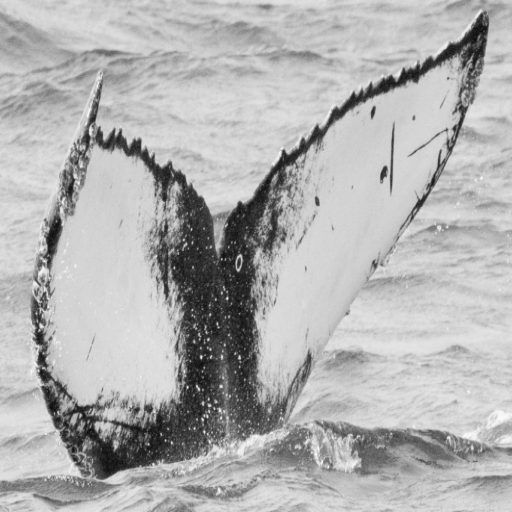

In [15]:
test_index = 2
test_tensor = data.gallery.__getitem__(test_index)[0]
test_img = torchvision.transforms.ToPILImage()(test_tensor)
test_img

15170
w_9ba4a9a


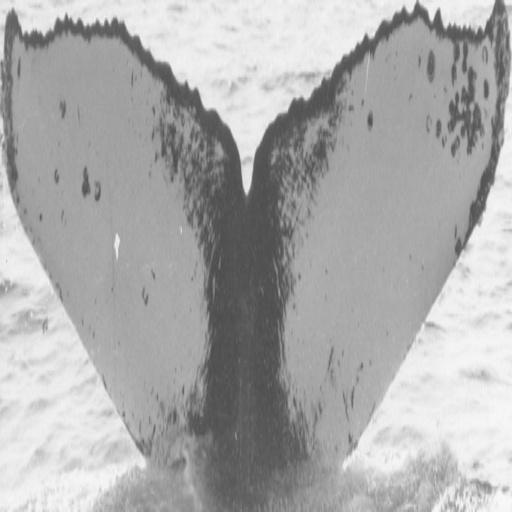

In [16]:
sim_i = sim_mat[test_index,:]
best_index = np.argsort(sim_i)[::-1][0]
print(best_index)
train_tensor = data.train.__getitem__(best_index)[0]
train_img = torchvision.transforms.ToPILImage()(train_tensor)
print(data.train.labels[best_index])
train_img

## Image augmentation

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import absolute_import, print_function
import argparse
import ast
import torch
from torchvision import transforms
import pandas as pd
from torch.backends import cudnn

import models
import DataSet
import json
from evaluations import Recall_at_ks, pairwise_similarity, extract_features, Compute_top_k
from utils.serialization import load_checkpoint, load_latest
from utils import display
from matplotlib import pyplot as plt
import PIL

cudnn.benchmark = True

In [ ]:
width = 512
data = DataSet.create('whale', width=width)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((width,width)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.01,
                           saturation=0.01,
                           hue=0.01),
    transforms.Grayscale(3),
    transforms.RandomRotation(8),
    transforms.RandomResizedCrop(size=512,
                                 scale=(0.95,1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[50/255.0], 
                         std=[1.0/255.0])
])

In [ ]:
image = data.train.__getitem__(29)[0]
image = transforms.ToPILImage()(preprocess(image))
image